# Purpose: Early experimentation with preprocessing the differenced image in search of transients

In [84]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [1]:
from astropy.io import fits
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
import sep
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
import matplotlib.pyplot as plt
import numpy as np

In [2]:
size = 150
def normalize(arr, samples=20000):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)

    return (arr - np.median(arr, axis=(0, 1), keepdims=True)) / np.std(arr, axis=(0, 1), keepdims=True)

In [3]:
diff_file = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0714/406759/ztf_20180714406759_000692_zr_c01_o_q2_scimrefdiffimg.fits.fz"
sci_file = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0714/406759/ztf_20180714406759_000692_zr_c01_o_q2_sciimg.fits"
ref_file = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/ref/000/field000692/zr/ccd01/q2/ztf_000692_zr_c01_q2_refimg.fits"

In [4]:
diff = fits.getdata(diff_file)
sci = fits.getdata(sci_file)
ref = fits.getdata(ref_file)

In [7]:
diff[diff < -4000] = np.nan

In [8]:
diff_bkg = sep.Background(diff)

In [9]:
print(np.max(diff_bkg.rms()))

5.0597954


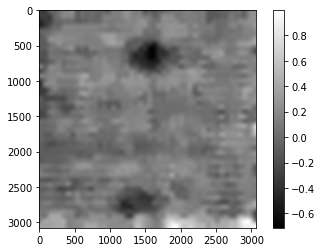

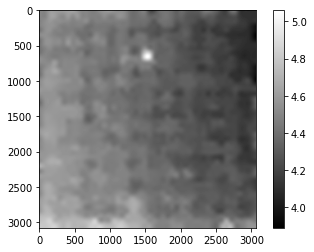

In [10]:
plt.imshow(diff_bkg, cmap="gray")
plt.colorbar()
plt.figure()
plt.imshow(diff_bkg.rms(), cmap="gray")
plt.colorbar()

/opt/anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([4.00000e+00, 1.60000e+01, 3.90000e+01, 1.94000e+02, 8.75910e+04,
        8.71201e+06, 2.79000e+02, 6.10000e+01, 1.30000e+01, 2.00000e+00]),
 array([-3904.5173  , -3125.773   , -2347.0286  , -1568.2843  ,
         -789.5399  ,   -10.795532,   767.94885 ,  1546.6932  ,
         2325.4375  ,  3104.182   ,  3882.9263  ], dtype=float32),
 <a list of 10 Patch objects>)

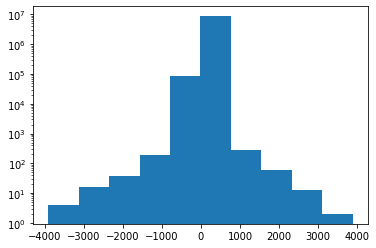

In [11]:
plt.hist(diff.flatten(), log=True)
# plt.hist(diff.flatten(), np.arange(-20, 20, 0.01), log=False)

In [74]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

size = 5
sigma = size * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=size, y_size=size)
kernel.normalize()

segm = detect_sources(diff, np.nanstd(diff), 5, connectivity=8, filter_kernel=kernel)
print("done")

info = [source for source in source_properties(diff, segm) if source.elongation > 2]

done


In [75]:
pos = np.array([((source.bbox.ixmin + source.bbox.ixmax) // 2, (source.bbox.iymin + source.bbox.iymax) // 2) for source in info])
lengths = np.sqrt([((source.bbox.ixmin - source.bbox.ixmax) ** 2 + (source.bbox.iymin - source.bbox.iymax) ** 2) for source in info])

In [76]:
print(np.max(lengths))

21.540659228538015


In [77]:
import sklearn.cluster

In [78]:
clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=100, linkage="complete")
fit = clustering.fit(pos)
labels = clustering.fit_predict(pos)

In [79]:
print(np.max(labels))

101


In [80]:
for i in range(np.max(labels) + 1):
    positions = pos[np.where(labels == 0)[0]]
    x1, x2 = np.min(positions[:, 0]), np.max(positions[:, 0])
    y1, y2 = np.min(positions[:, 1]), np.max(positions[:, 1])
    if x2 - x1 > 120 or y2 - y1 > 120:
        print(i)

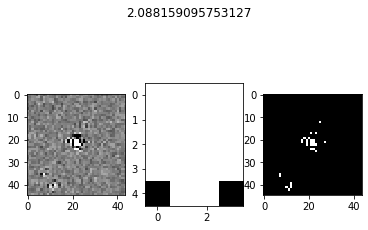

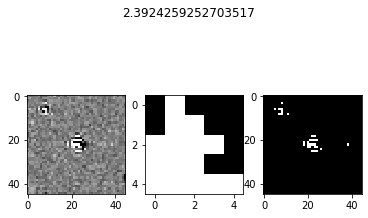

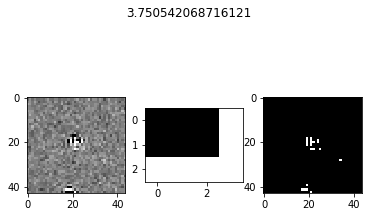

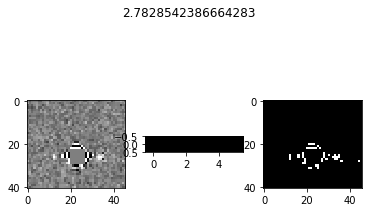

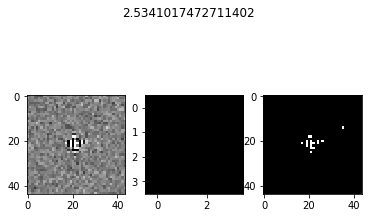

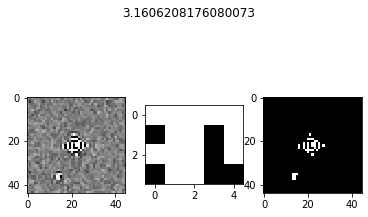

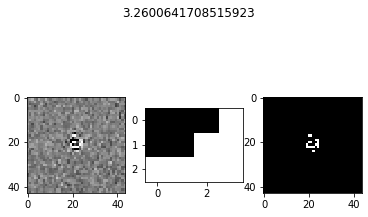

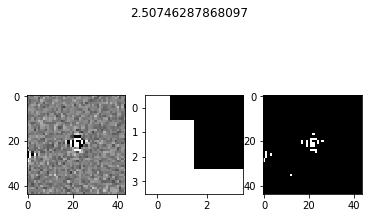

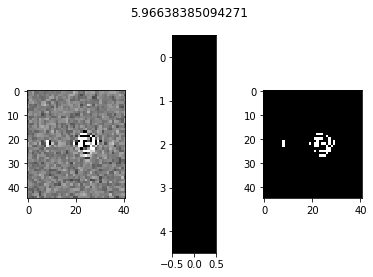

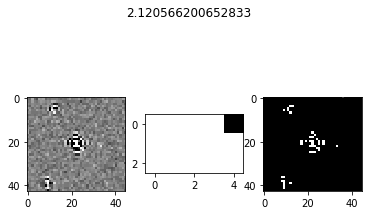

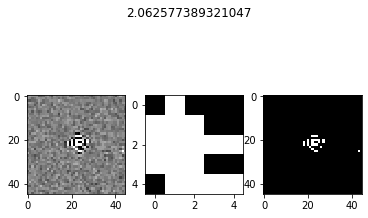

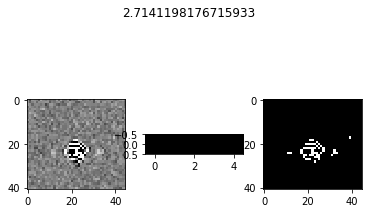

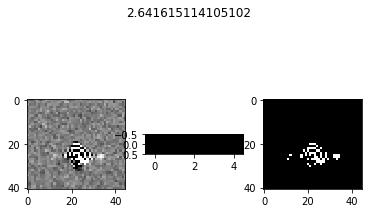

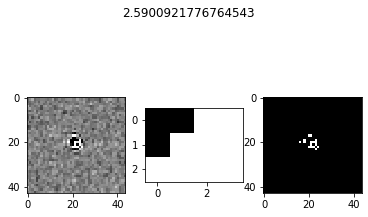

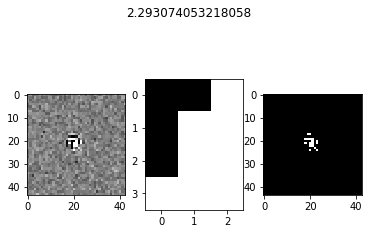

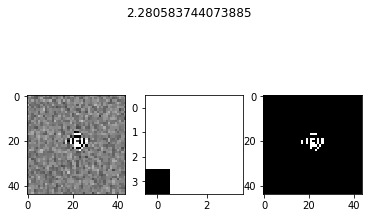

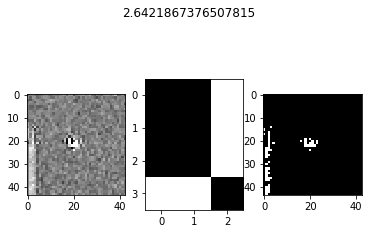

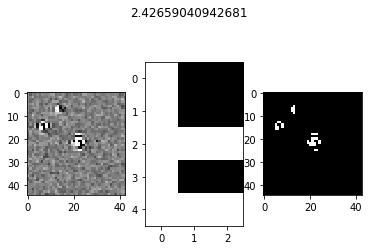

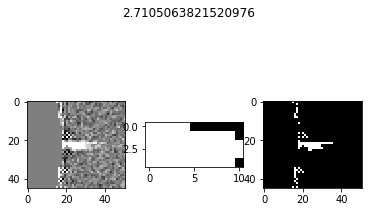

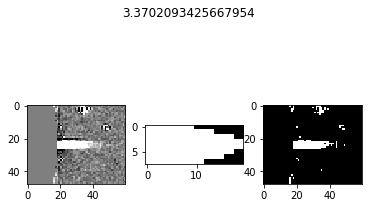

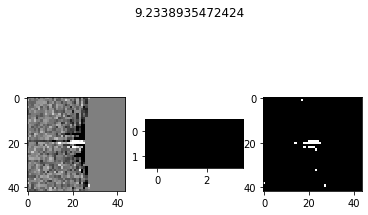

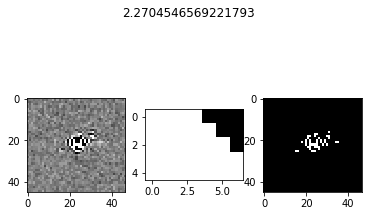

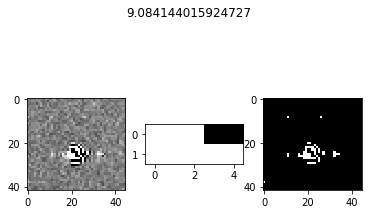

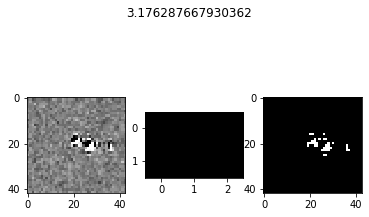

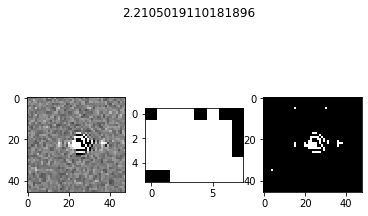

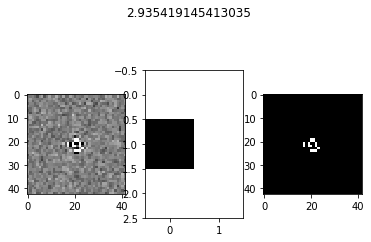

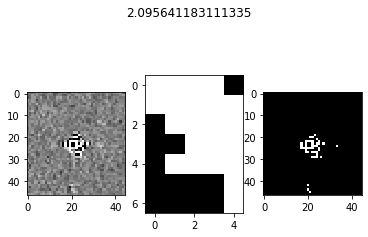

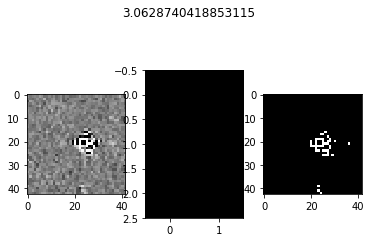

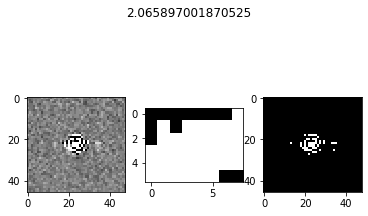

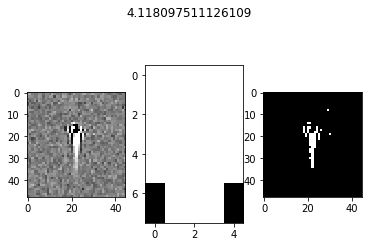

In [82]:
mask = diff > np.nanstd(diff)
for source in info[:30]:
    y1 = max(source.bbox.iymin - 20, 0)
    y2 = source.bbox.iymax + 20
    x1 = max(source.bbox.ixmin - 20, 0)
    x2 = source.bbox.ixmax + 20
#     print(source.bbox, y1, y2, x1, x2)
    crop = np.array(diff[y1:y2, x1:x2])
    crop[~np.isfinite(crop)] = 0
    plt.figure()
    plt.suptitle(source.elongation)
    plt.subplot(1, 3, 1)
    plt.imshow(normalize(crop), cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow((~source.data_cutout_ma.mask), cmap="gray")
    plt.subplot(1, 3, 3)
    plt.imshow(mask[y1:y2, x1:x2], cmap="gray")

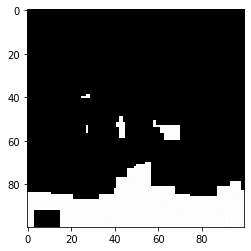

In [59]:
plt.imshow(normalize(diff[:100, 750:850]), cmap="gray")

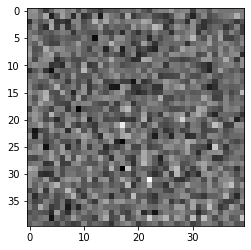

In [57]:
plt.imshow(normalize(diff[700:740, 700:740]), cmap="gray")

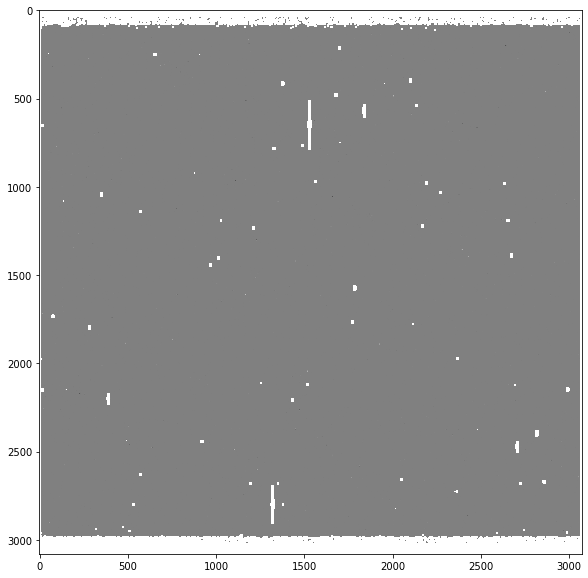

In [104]:
plt.figure(figsize=(10, 10))
plt.imshow(diff, cmap="gray")